In [2]:
# Importing file extension and path handling libraries
import zipfile
import os

# Importing data manipulation and transformation libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline


# Importing text handling libraries
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import regex as re

# Importing vizualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import validation_curve


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# with zipfile.ZipFile("bbc-fulltext.zip", 'r') as zippath: 
#    zippath.extractall()

In [4]:
#  Extracting text from the files and creating a dataset
main_path = r'bbc/'
main_df = pd.DataFrame(columns = ['Text', 'Category'])


for folder in os.listdir(main_path):
    try:
        for file in os.listdir(main_path + '\\' + folder): 
        
            with open(os.path.join(main_path, folder, file), 'rt') as txt_file:
                row_dict = {'Text' : "".join(txt_file.readlines()), 'Category': folder}
                main_df = main_df.append(row_dict, ignore_index = True)
                txt_file.close()
        
    except NotADirectoryError:
        continue

    
main_df.head()

,Text,Category
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",business
1,"Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""\n\nWorries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent comments in 

In [5]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      2225 non-null   object
 1   Category  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
main_df.loc[3, 'Text']

'High fuel prices hit BA\'s profits\n\nBritish Airways has blamed high fuel prices for a 40% drop in profits.\n\nReporting its results for the three months to 31 December 2004, the airline made a pre-tax profit of Â£75m ($141m) compared with Â£125m a year earlier. Rod Eddington, BA\'s chief executive, said the results were "respectable" in a third quarter when fuel costs rose by Â£106m or 47.3%. BA\'s profits were still better than market expectation of Â£59m, and it expects a rise in full-year revenues.\n\nTo help offset the increased price of aviation fuel, BA last year introduced a fuel surcharge for passengers.\n\nIn October, it increased this from Â£6 to Â£10 one-way for all long-haul flights, while the short-haul surcharge was raised from Â£2.50 to Â£4 a leg. Yet aviation analyst Mike Powell of Dresdner Kleinwort Wasserstein says BA\'s estimated annual surcharge revenues - Â£160m - will still be way short of its additional fuel costs - a predicted extra Â£250m. Turnover for the q

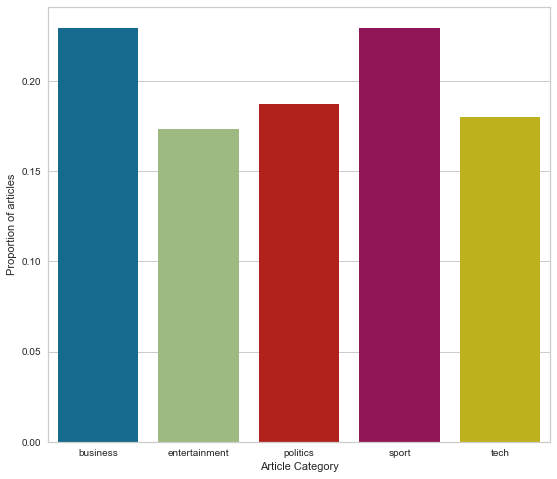

In [7]:
# Vizualizing the propotion of news articles in each class 
articles_per_cat = main_df.groupby("Category").count().reset_index(drop = False)

articles_per_cat.columns = ['Category', 'No of articles per category']

plt.figure(figsize = (9, 8))
sns.barplot(x = articles_per_cat.Category, y = articles_per_cat['No of articles per category']/sum(articles_per_cat['No of articles per category']))
plt.xlabel("Article Category")
plt.ylabel("Proportion of articles") 
plt.show()

The distribution of articles across different classes seemed to be balanced.

In [8]:
# Let's make a news length feature to see how the length of all the articles across different classes fair against each other
main_df['News_length'] = main_df['Text'].apply(lambda x: len(x))
main_df['News_length'].describe()

count     2225.000000
mean      2265.790562
std       1364.305951
min        503.000000
25%       1448.000000
50%       1967.000000
75%       2804.000000
max      25485.000000
Name: News_length, dtype: float64

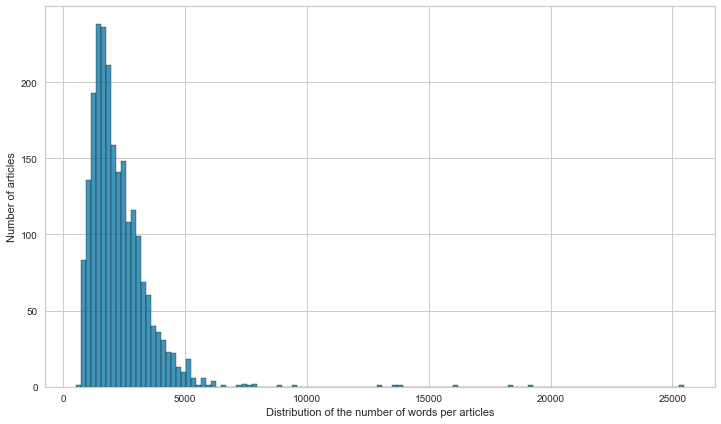

In [9]:
# districution of the length of the articles
plt.figure(figsize = (12, 7))
sns.histplot(main_df['News_length'])
plt.xlabel("Distribution of the number of words per articles")
plt.ylabel("Number of articles")
plt.show()

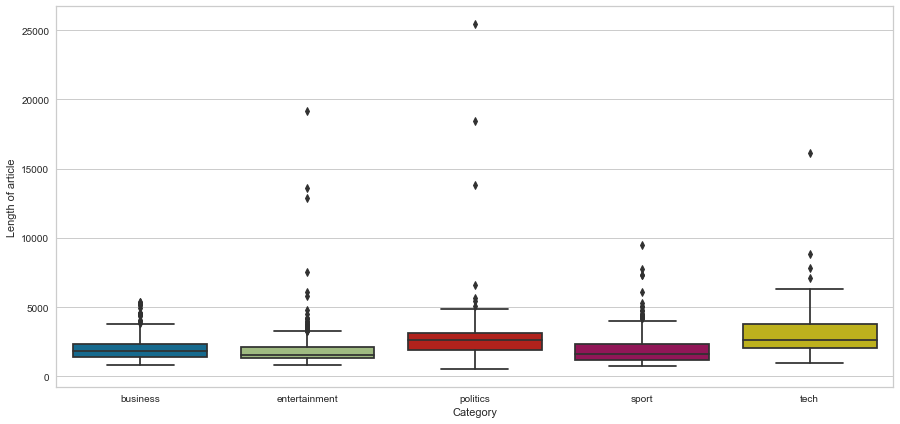

In [10]:
# Boxplots of the length of articles across different categories
sns.set_style()
plt.figure(figsize = (15, 7))
sns.boxplot(x = 'Category', y = 'News_length', data = main_df)
plt.xlabel("Category")
plt.ylabel("Length of article")
plt.show()

There seems to be a high number of outliers in the politics and the entertainment category, as opposed to the others. Business category has the most concise articles of all. Let's examine the plot closely by removing the outliers. 

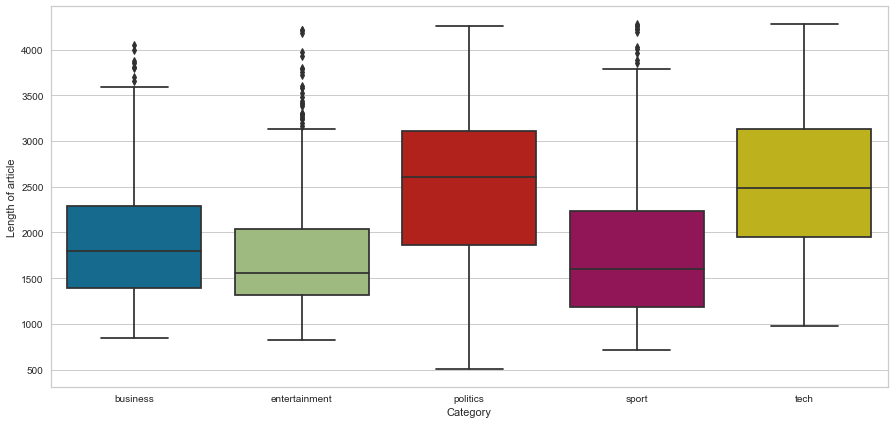

In [11]:
# Boxplots of the length of news articles across different categories  
news_length_plot = main_df[main_df.News_length < np.quantile(main_df['News_length'], 0.95)]

sns.set_style()
plt.figure(figsize = (15, 7))
sns.boxplot(x = 'Category', y = 'News_length', data = news_length_plot)
plt.xlabel("Category")
plt.ylabel("Length of article")
plt.show()

From this plot, it is pretty clear that politics and tech categories, in the first glance, look like they have lengthier articles. There is more variability in length in the 25th to 50th percentile articles of the politics category while the variablility in the tech category in the 50th to 75th percentile is higher than its 25th to 50th percentile. 

In [12]:
# Cleans the news articles and preprocesses it
def preprocess_text(text): 
    
    preprocessed_text = re.sub("\n\r", "", text)
    
     # remove apostrophe s ('s) from the text 
    possessive_pronouns = re.sub("\'s", "", preprocessed_text)
    
    #remove symbols, punctuations and numbers 
    punct_und_symbols = re.sub(r'[^a-zA-Z]', " ", possessive_pronouns)

    # replace multiple whitespaces with just one white space
    space_replacement = re.sub("\s\s+", " ", punct_und_symbols)
    
    # Remove words which have 2 characters or less
    filtering = re.sub(" \w{2} ", "", space_replacement)
    
    # Converting all the words in the tweets to lower case to standardize it for pos tagging and entity extraction
    lowercase = space_replacement.lower()
    
    # Setting stopwords from nltk 
    stop_words = list(stopwords.words("english"))
    
    # Remove stopwords
    lowercase_filtered = [word for word in lowercase.split(" ") if word not in stop_words]
    
    return " ".join(lowercase_filtered)


# Vectorizing the fumction for better performance
vector_preprocess = np.vectorize(preprocess_text)

main_df['Text_preprocessed'] = main_df['Text'].apply(lambda x: vector_preprocess(x))
main_df.head()

,Text,Category,News_length,Text_preprocessed
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",business,2560,ad sales boost time warner profit quarterly profits us media giant timewarner jumped bn three months december year earlier firm one biggest investors google benefited sales high speed internet connections higher advert sales timewarner said fourth quarter sales rose bn bn profits buoyed one gains offset profit dip warner bros less users aol time warner said friday owns search engine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding three quarters however company said aol underlying profit exceptional items rose back stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aol existing customers high speed broadband timewarner also restate results following probe us securities exchange commission sec close concluding time warner fourth quarter profits slightly better analysts expectations film division saw profits slump helped box office flops alexander catwoman sharp contrast year earlier third final film lord rings trilogy boosted results full year timewarner posted profit bn performance revenues grew bn financial performance strong meeting exceeding full year objectives greatly enhancing flexibility chairman chief executive richard parsons said timewarner projecting operating earnings growth around also expects hig

In [13]:
# Lemmatizes the function and converts it to its root form 
def lemmatize(text): 
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    news_words = text.split(" ")
    
    for word in news_words:
        lemmatized_text.append(lemmatizer.lemmatize(word))
        
        
    return  " ".join(lemmatized_text)

    

In [14]:
# Lemmatizing the articles
main_df['Text_preprocessed'] = main_df['Text_preprocessed'].apply(lemmatize)
main_df.head()

,Text,Category,News_length,Text_preprocessed
0,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",business,2560,ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn three month december year earlier firm one biggest investor google benefited sale high speed internet connection higher advert sale timewarner said fourth quarter sale rose bn bn profit buoyed one gain offset profit dip warner bros le user aol time warner said friday owns search engine google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company said aol underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aol existing customer high speed broadband timewarner also restate result following probe u security exchange commission sec close concluding time warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped box office flop alexander catwoman sharp contrast year earlier third final film lord ring trilogy boosted result full year timewarner posted profit bn performance revenue grew bn financial performance strong meeting exceeding full year objective greatly enhancing flexibility chairman chief executive richard parson said timewarner projecting operating earnings growth around also expects higher revenue wider profit margin timew

In [15]:
# Resetting the columns in the dataset to make it look cleaner
columns = ['Text_preprocessed', 'News_length', 'Category']

df = main_df[columns].copy()

df['Category'] = df['Category'].astype('category')
# Converting categories to integer equivalents 
df['Cat_codes'] = df['Category'].cat.codes
df.head()

,Text_preprocessed,News_length,Category,Cat_codes
0,ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn three month december year earlier firm one biggest investor google benefited sale high speed internet connection higher advert sale timewarner said fourth quarter sale rose bn bn profit buoyed one gain offset profit dip warner bros le user aol time warner said friday owns search engine google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company said aol underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aol existing customer high speed broadband timewarner also restate result following probe u security exchange commission sec close concluding time warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped box office flop alexander catwoman sharp contrast year earlier third final film lord ring trilogy boosted result full year timewarner posted profit bn performance revenue grew bn financial performance strong meeting exceeding full year objective greatly enhancing flexibility chairman chief executive richard parson said timewarner projecting operating earnings growth around also expects higher revenue wider profit margin timewarner restate account part effort resolve inquiry aol u market regulator already offered pay settle charge deal review sec company said unable estimate amount needed set aside legal reserve previously set intends adjust way account deal german music publisher bertelsmann purchase stake aol europe reported advertising revenue book sale stake aol europe loss value stake,2560,business,0
1,dollar gain greenspan speech dollar hit highest level euro almost three month federal reserve head said u trade deficit set stabilise alan greenspan highlighted u government willingness curb spending rising household saving factor may help reduce late trading new york dollar reached euro thursday market concern deficit hit greenback recent month friday federal reserve chairman mr greenspan speech london ahead meeting g finance minister sent dollar higher earlier tumbled back worse expected u job data think chairman taking much sanguine view current account deficit taken time said robert sinche head currency strategy bank america new york taking longer term view laying set condition current account deficit improve year next worry deficit concern china however remain china currency remains pegged dollar u currency sharp fall recent month therefore made chinese export price highly competitive call shift beijing policy fallen deaf ear despite recent comment major chinese newspaper time ripe loosening peg g meeting thought unlikely produce meaningful movement chinese policy meantime u federal reserve decision february boost interest rate quarter point sixth move many month opened differential european rate half point window believe could enough keep u asset looking attractive could help prop dollar recent fall partly result big budget deficit well u yawning current account gap need funded buying u bond asset foreign firm government white house announce budget monday many commentator believe deficit remain close half trillion dollar,2252,business,0
2,yukos unit buyer face loan claim owner embattled russian oil giant yukos ask buyer former production unit pay back loan state owned rosneft bought yugansk unit bn sale forced russia part settle bn tax claim yukos yukos owner menatep group say ask rosneft repay loan yugansk secured asset rosneft already face similar repayment demand foreign bank legal expert said rosneft purchase yugansk would include obligation pledged asset rosneft pay real money creditor avoid seizure yugansk asset said moscow based u lawyer jamie firestone connected case menatep group managing director tim osborne told reuters news agency default f

In [150]:
# Sanity Check
df[['Category', 'Cat_codes']].value_counts()

Category       Cat_codes
sport          3            511
business       0            510
politics       2            417
tech           4            401
entertainment  1            386
dtype: int64

In [151]:
# Making a dictionary of category and its corresponding code
cat_codes_dict = dict(zip(df['Category'].cat.categories, df['Category'].cat.codes.unique()))
cat_codes_dict

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [152]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Text_preprocessed'], df['Cat_codes'], test_size = 0.22, random_state = 42)


In [153]:
# frequency-based word vectors hyperparameters
ngrams = (1, 2)
min_doc = 8
max_doc = 895
max_words = 500

In [186]:
# Creating a bag of words modelsto use frequency based word features for analysis tasks
count_vec = CountVectorizer(ngram_range = ngrams, stop_words = None, lowercase = False, 
                           min_df = min_doc, max_df = max_doc, max_features = max_words)

word_vectors_train_cv = count_vec.fit_transform(X_train).toarray()
word_vectors_test_cv = count_vec.transform(X_test).toarray()
word_vectors_train_cv.shape

(1735, 500)

In [187]:
# Creating a a tf-idf based word vectors to use them as features for classification task 
tfidf = TfidfVectorizer(ngram_range = ngrams, stop_words = None, lowercase = False, 
                        min_df = min_doc, max_df = max_doc, max_features = max_words)


word_vectors_train_tfidf = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

word_vectors_test_tfidf = tfidf.transform(X_test).toarray()
labels_test = y_test
word_vectors_test_tfidf.shape

(490, 500)

In [188]:
word_vectors_train_cv.ndim

2

In [156]:
# Encodings of words as numerical indices 
tfidf.vocabulary_

{'band': 33,
 'take': 427,
 'break': 51,
 'plan': 333,
 'following': 162,
 'statement': 419,
 'record': 367,
 'company': 92,
 'time': 443,
 'working': 493,
 'however': 205,
 'would': 495,
 'due': 126,
 'top': 449,
 'three': 442,
 'hit': 198,
 'including': 210,
 'four': 168,
 'number': 311,
 'one': 317,
 'since': 403,
 'first': 160,
 'single': 404,
 'include': 209,
 'go': 181,
 'school': 387,
 'david': 112,
 'member': 277,
 'made': 260,
 'album': 12,
 'well': 482,
 'best': 42,
 'act': 5,
 'award': 30,
 'british': 53,
 'group': 188,
 'action': 6,
 'film': 155,
 'version': 466,
 'show': 401,
 'playing': 337,
 'music': 297,
 'seen': 395,
 'song': 411,
 'play': 334,
 'recent': 366,
 'big': 45,
 'winner': 487,
 'ireland': 220,
 'based': 35,
 'prize': 348,
 'point': 338,
 'public': 357,
 'former': 165,
 'international': 217,
 'beat': 37,
 'williams': 485,
 'fan': 149,
 'performance': 329,
 'star': 416,
 'success': 423,
 'came': 61,
 'third': 440,
 'final': 156,
 'think': 439,
 'lot': 257,
 'm

In [197]:
# Performing a Chi2 test to find out the most correlated features for each category - using the bag of words frequancy based features
print("Most correlated features for word frequency vectors for each category\n")

for cat, code in cat_codes_dict.items(): 
    chi_sq_features_cv = chi2(word_vectors_train_cv, labels_train == code)
    indices = np.argsort(chi_sq_features_cv[0])
    feature_names = np.array(count_vec.get_feature_names())[indices]
    unigrams = [uni for uni in feature_names if len(uni.split(' ')) == 1]
    bigrams = [bi for bi in feature_names if len(bi.split(' ')) == 2]
    print(f"{cat.title()} category")
    print("  Most Correlated unigrams:\n -{}".format('\n -'.join(unigrams[-5:])))
    print("  Most Correlated bigrams:\n -{}".format('\n -'.join(bigrams[-3:])))
    print("\n")

Most correlated features for word frequency vectors for each category

Business category
  Most Correlated unigrams:
 -share
 -growth
 -oil
 -bank
 -bn
  Most Correlated bigrams:
 -mr blair
 -year old
 -chief executive


Entertainment category
  Most Correlated unigrams:
 -star
 -actor
 -best
 -award
 -film
  Most Correlated bigrams:
 -mr brown
 -prime minister
 -mr blair


Politics category
  Most Correlated unigrams:
 -tory
 -election
 -mr
 -party
 -labour
  Most Correlated bigrams:
 -mr brown
 -prime minister
 -mr blair


Sport category
  Most Correlated unigrams:
 -champion
 -mr
 -cup
 -england
 -match
  Most Correlated bigrams:
 -mr blair
 -said mr
 -year old


Tech category
  Most Correlated unigrams:
 -computer
 -user
 -phone
 -mobile
 -technology
  Most Correlated bigrams:
 -prime minister
 -mr blair
 -said mr




In [195]:
# Performing a Chi2 test to find out the most correlated features for each category - using the tf-idf based word vectors 
print("Most correlated features for tf-idf word vectors for each category\n")

for cat, code in cat_codes_dict.items(): 
    chi_sq_features_tfidf = chi2(word_vectors_train_tfidf, labels_train == code)
    indices = np.argsort(chi_sq_features_tfidf[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [uni for uni in feature_names if len(uni.split(' ')) == 1]
    bigrams = [bi for bi in feature_names if len(bi.split(' ')) == 2]
    print(f"{cat.title()} category")
    print("  Most Correlated unigrams:\n -{}".format('\n -'.join(unigrams[-5:])))
    print("  Most Correlated bigrams:\n -{}".format('\n -'.join(bigrams[-3:])))
    print("\n")
    

Most correlated features for tf-idf word vectors for each category

Business category
  Most Correlated unigrams:
 -share
 -growth
 -oil
 -bank
 -bn
  Most Correlated bigrams:
 -mr blair
 -year old
 -chief executive


Entertainment category
  Most Correlated unigrams:
 -album
 -actor
 -band
 -award
 -film
  Most Correlated bigrams:
 -mr brown
 -prime minister
 -mr blair


Politics category
  Most Correlated unigrams:
 -blair
 -election
 -tory
 -party
 -labour
  Most Correlated bigrams:
 -prime minister
 -mr brown
 -mr blair


Sport category
  Most Correlated unigrams:
 -coach
 -england
 -champion
 -cup
 -match
  Most Correlated bigrams:
 -said mr
 -mr blair
 -year old


Tech category
  Most Correlated unigrams:
 -software
 -mobile
 -computer
 -user
 -technology
  Most Correlated bigrams:
 -mr blair
 -year old
 -said mr




In [214]:
bigrams

['said would',
 'chief executive',
 'last year',
 'told bbc',
 'year old',
 'mr brown',
 'prime minister',
 'mr blair',
 'said mr']

The total number of bigrams selected by the vectorizers for a max of 500 words is just 6 and as it is observable, some bigrams are repeated for almost all the categories of news articles, like mr blair and year old. 

The small number of bigrams in 500 word features and the repetitive bigrams in all the categories show that the bigrams are correlated lesser with each category enough to make a difference in the predictive power of the features. 

It would would be better if the bigrams are removed and the modelling is done with just unigram features. 

In [215]:
# frequency-based word vectors hyperparameters - retuning the features
ngrams = (1, 1)
min_doc = 8
max_doc = 895
max_words = 500

In [216]:
count_vec = CountVectorizer(ngram_range = ngrams, stop_words = None, lowercase = False, 
                           min_df = min_doc, max_df = max_doc, max_features = max_words)

word_vectors_train_cv = count_vec.fit_transform(X_train).toarray()
word_vectors_test_cv = count_vec.transform(X_test).toarray()
word_vectors_train_cv.shape

(1735, 500)

In [217]:
tfidf = TfidfVectorizer(ngram_range = ngrams, stop_words = None, lowercase = False, 
                        min_df = min_doc, max_df = max_doc, max_features = max_words)


word_vectors_train_tfidf = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

word_vectors_test_tfidf = tfidf.transform(X_test).toarray()
labels_test = y_test
word_vectors_test_tfidf.shape

(490, 500)

In [158]:
feature_names

array(['yet', 'thing', 'result', 'line', 'run', 'choice', 'enough',
       'include', 'support', 'keep', 'take', 'business', 'come', 'give',
       'next', 'told bbc', 'always', 'head', 'account', 'key', 'car',
       'group', 'demand', 'wanted', 'another', 'go', 'trying', 'better',
       'big', 'important', 'part', 'form', 'far', 'campaign', 'announced',
       'term', 'must', 'needed', 'see', 'move', 'among', 'common',
       'possible', 'well', 'lot', 'going', 'november', 'done', 'month',
       'action', 'real', 'thought', 'want', 'report', 'say', 'cost',
       'open', 'pay', 'low', 'top', 'success', 'song', 'play', 'end',
       'away', 'march', 'bill', 'analyst', 'world', 'area', 'home',
       'warned', 'behind', 'view', 'set', 'centre', 'future', 'time',
       'really', 'rather', 'list', 'level', 'recent', 'start', 'child',
       'programme', 'within', 'concern', 'put', 'competition', 'le',
       'playing', 'european', 'bbc', 'past', 'never', 'still',
       'president', '

In [218]:
# Using a multinomial Naive Bayes algorithm to learn the probabilities of the word frequency-based features belonging to a particular category
naive_bayes_cv = MultinomialNB()
naive_bayes_cv.fit(word_vectors_train_cv, labels_train)
train_preds_cv = naive_bayes_cv.predict(word_vectors_train_cv)
print(f"Train accuracy for Bag of words features: {accuracy_score(labels_train, train_preds_cv)}")

Train accuracy for Bag of words features: 0.9636887608069165


In [219]:
# Test dataset accuracy
test_preds_cv = naive_bayes_cv.predict(word_vectors_test_cv)
print(f"Test accuracy for bag of words features: {accuracy_score(labels_test, test_preds_cv)}") 

Test accuracy for bag of words features: 0.9489795918367347


In [220]:
# Training a Multinomial Naive bayes model using the tfidf features 
naive_bayes_tfidf = MultinomialNB()
naive_bayes_tfidf.fit(word_vectors_train_tfidf, labels_train)
train_preds_tfidf = naive_bayes_tfidf.predict(word_vectors_train_tfidf)
print(f"Train accuracy for Tf-Idf features: {accuracy_score(labels_train, train_preds_tfidf)}")

Train accuracy for Tf-Idf features: 0.960806916426513


In [221]:
# Test dataset accuracy using tf-idf word vector-based featues
test_preds_tfidf = naive_bayes_tfidf.predict(word_vectors_test_tfidf)
print(f"Test accuracy for Tf-idf features: {accuracy_score(labels_test, test_preds_tfidf)}")

Test accuracy for Tf-idf features: 0.9510204081632653


The performance of the Multinomial Naive Bayes algorithm on the bag of words features and the tf-idf features is identical with the tf-idf features performing marginally better. Let's try tuning the tf-idf features with a different set of hyperparameters to increase the predictive power of the model. 

In [265]:
# tf-idf vectorizer hyperparameter tuning 
# Performing hyperparameter tuning on the word vector features allows us to use a simpler model with more robust features

params_dict = {'tfidf__min_df' : [5, 7, 10, 12, 15], 
               'tfidf__max_df' : list(range(700, 900, 42)),
               'tfidf__max_features': list(range(500, 2000, 150))}



pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= None, lowercase = False)),
    ('clf', MultinomialNB())])

folds = KFold(5, random_state = 42)
cv_obj = RandomizedSearchCV(pipe, param_distributions = params_dict, n_iter = 20, 
                            scoring = 'accuracy', cv = folds, return_train_score = True, random_state = 42)

cv_obj.fit(X_train, y_train)



C:\Users\sachi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('clf', MultinomialNB())]),
                   n_iter=20,
                   param_distributions={'tfidf__max_df': [700, 742, 784, 826,
                                                          868],
                                        'tfidf__max_features': [500, 650, 800,
                                                                950, 1100, 1250,
                                                                1400, 1550,
                                                                1700, 1850],
                                        'tfidf__min_df': [5, 7, 10, 12, 15]},
                   random_state=42, return_train_score=True,
                   scoring='accuracy')

In [266]:
# Results of hyperparameter tuning
cv_results = pd.DataFrame(cv_obj.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__min_df,param_tfidf__max_features,param_tfidf__max_df,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.228285,0.018118,0.051755,0.007289,10,1700,784,"{'tfidf__min_df': 10, 'tfidf__max_features': 1700, 'tfidf__max_df': 784}",0.985591,0.979827,...,0.971758,0.010844,3,0.984870,0.984870,0.987032,0.985591,0.984150,0.985303,0.000977
1,0.232944,0.028177,0.050245,0.006115,7,650,700,"{'tfidf__min_df': 7, 'tfidf__max_features': 650, 'tfidf__max_df': 700}",0.974063,0.971182,...,0.961960,0.009713,17,0.970461,0.970461,0.974784,0.973343,0.976225,0.973055,0.002305
2,0.247446,0.021183,0.049954,0.006756,10,1850,742,"{'tfidf__min_df': 10, 'tfidf__max_features': 1850, 'tfidf__max_df': 742}",0.985591,0.982709,...,0.971758,0.011585,3,0.984150,0.985591,0.988473,0.984870,0.984870,0.985591,0.001511
3,0.251521,0.037846,0.051368,0.003884,5,800,742,"{'tfidf__min_df': 5, 'tfidf__max_features': 800, 'tfidf__max_df': 742}",0.971182,0.971182,...,0.961960,0.008817,15,0.971182,0.972622,0.977666,0.973343,0.976225,0.974207,0.002385
4,0.221586,0.003598,0.043964,0.006377,10,800,784,"{'tfidf__min_df': 10, 'tfidf__max_features': 800, 'tfidf__max_df': 784}",0.971182,0.971182,...,0.961960,0.008817,15,0.972622,0.972622,0.977666,0.975504,0.975504,0.974784,0.001933
5,0.228718,0.013615,0.051885,0.010059,7,1400,826,"{'tfidf__min_df': 7, 'tfidf__max_features': 1400, 'tfidf__max_df': 826}",0.979827,0.976945,...,0.971758,0.008028,6,0.982709,0.981988,0.983429,0.982709,0.983429,0.982853,0.000539
6,0.245984,0.017991,0.050691,0.008426,10,1850,826,"{'tfidf__min_df': 10, 'tfidf__max_features': 1850, 'tfidf__max_df': 826}",0.985591,0.982709,...,0.972334,0.011324,2,0.984150,0.985591,0.987752,0.984870,0.985591,0.985591,0.001206
7,0.240441,0.027114,0.050573,0.010148,15,1400,826,"{'tfidf__min_df': 15, 'tfidf__max_features': 1400, 'tfidf__max_df': 826}",0.974063,0.974063,...,0.967147,0.009222,9,0.981268,0.981268,0.982709,0.981268,0.982709,0.981844,0.000706
8,0.222980,0.028602,0.049010,0.003984,15,650,700,"{'tfidf__min_df': 15, 'tfidf__max_features': 650, 'tfidf__max_df': 700}",0.974063,0.971182,...,0.961960,0.009713,17,0.971182,0.969741,0.975504,0.973343,0.974784,0.972911,0.002166
9,0.222357,0.020951,0.052246,0.009274,15,500,784,"{'tfidf__min_df': 15, 'tfidf__max_features': 500, 'tfidf__max_df': 784}",0.962536,0.971182,...,0.955620,0.013952,19,0.965418,0.961095,0.969020,0.963256,0.966859,0.965130,0.002757


In [267]:
# Hyperparameters of the best performing model 
cv_obj.best_params_

{'tfidf__min_df': 5, 'tfidf__max_features': 1700, 'tfidf__max_df': 868}

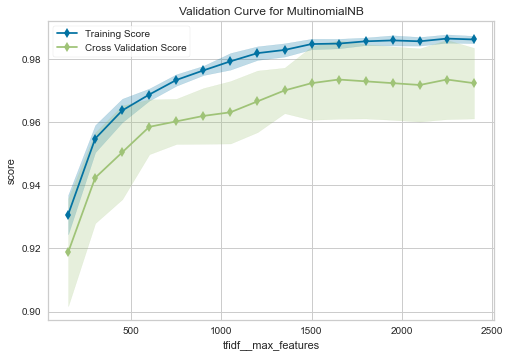

In [262]:
# Plotting the training and test set accuracies for the cross validation performed using max features as the variable  
val_curve = validation_curve(pipe, X_train, y_train, param_name="tfidf__max_features", n_jobs=-1,
      param_range=np.arange(150, 2500, 150), cv=5, scoring="accuracy", size = (600,600))
val_curve.show()

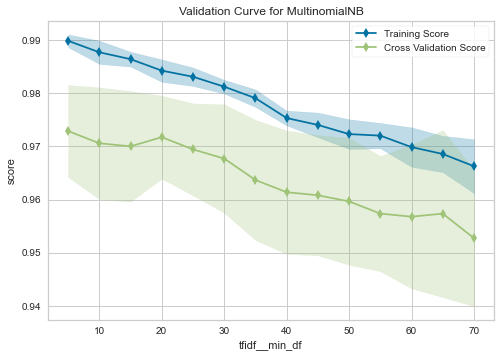

In [263]:
# Plotting the training and test set accuracies for the cross validation performed using min documents per word as the variable 
val_curve = validation_curve(pipe, X_train, y_train, param_name="tfidf__min_df", n_jobs=-1,
      param_range=np.arange(5, 75, 5), cv=5, scoring="accuracy", size = (600,600))
val_curve.show()

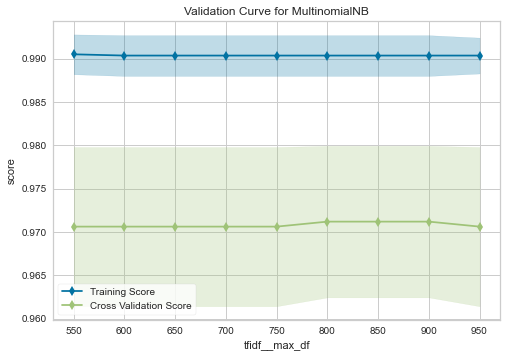

In [264]:
# Plotting the training and test set accuracies for the cross validation performed using max documents per word as the variable 
val_curve = validation_curve(pipe, X_train, y_train, param_name="tfidf__max_df", n_jobs=-1,
      param_range=np.arange(550, 1000, 50), cv=5, scoring="accuracy", size = (600,600))
val_curve.show()

From the validation curve plots above, the best hyperparameters observed are 1500 maximum word features, 20 doc at least for a word to be present in and 800 max docs for a word to be present in.

In [269]:
# Retraining the model with the best identified hyperparameters for the Tf-idf based word vector features
tfidf = TfidfVectorizer(min_df= 20, max_df = 800, max_features = 1500, stop_words = None, lowercase = False)
tfidf.fit(X_train)

word_vectors_train = tfidf.transform(X_train)
word_vectors_test = tfidf.transform(X_test)

train_labels = y_train
test_labels = y_test


In [270]:
mnnb = MultinomialNB()

mnnb.fit(word_vectors_train, y_train)

train_preds = mnnb.predict(word_vectors_train)
training_accuracy = accuracy_score(train_labels, train_preds)

test_preds = mnnb.predict(word_vectors_test)
testing_accuracy = accuracy_score(test_labels, test_preds)

print(f"Training accuracy score: {training_accuracy}")
print(f"Testing accuracy score: {testing_accuracy}")

Training accuracy score: 0.98328530259366
Testing accuracy score: 0.963265306122449


Since a simpler multinomial naive bayes model is able to deliver stellar results with tf-idf based word vector features, the need for experimenting with more complex models is not identified. 

However, since the training and test sets come from a single website's new articles (BBC), the model with feature vectors is able to hold up pretty easily. If a test dataset made of news articles from different websites is used to evaluate the model, the model might not quite hold up. In that case, word embeddings based features could be used to classify the news articles. 